# Introduction

This project, will interpret data from the National Parks Service about endangered species in different parks.

This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis.

This project will seek to answer these questions:

- What is the distribution of conservation status for species?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which animal is most prevalent and what is their distribution amongst parks?

## Data

There are two data sets. The first `csv` file has information about each species and the other has observations of species with park locations. This data will be used to analyze the goals of the project. 

In [332]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import chain
import string
%matplotlib inline

## Loading the Data

#### species

The `species_info.csv` contains information on the different species in the National Parks. The columns in the data set include:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status

#### observations

The `Observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [333]:
species_df = pd.read_csv('species_info.csv', encoding='utf-8');
observ_df = pd.read_csv('observations.csv', encoding='utf-8');

pd.set_option('display.expand_frame_repr', False);

#merging both data sets into a single file
biodiversity_df = pd.merge(species_df, observ_df, on = 'scientific_name', how = 'outer');
print(biodiversity_df);


             category                scientific_name                                       common_names conservation_status                            park_name  observations
0              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN                  Bryce National Park           130
1              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN            Yellowstone National Park           270
2              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN  Great Smoky Mountains National Park            98
3              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN               Yosemite National Park           117
4              Mammal                      Bos bison                              American Bison, Bison                 NaN  

## Data exploration

In [336]:
#print(biodiversity_df.columns);
#print(biodiversity_df.category.unique());
print(biodiversity_df.groupby("category").size());

category
Amphibian              328
Bird                  2364
Fish                   524
Mammal                1200
Nonvascular Plant     1332
Reptile                324
Vascular Plant       19560
dtype: int64


In [337]:
print(biodiversity_df.dtypes);

category               object
scientific_name        object
common_names           object
conservation_status    object
park_name              object
observations            int64
dtype: object


In [338]:
print(biodiversity_df.isna().sum());

category                   0
scientific_name            0
common_names               0
conservation_status    24752
park_name                  0
observations               0
dtype: int64


In [339]:
duplicates = biodiversity_df.duplicated();
print(duplicates.value_counts());

False    25601
True        31
dtype: int64


In [340]:
biodiversity_df = biodiversity_df.drop_duplicates();
duplicates_bio = biodiversity_df.duplicated();
print(duplicates_bio.value_counts());
print(biodiversity_df.groupby("conservation_status").size());


False    25601
dtype: int64
conservation_status
Endangered             80
In Recovery            24
Species of Concern    732
Threatened             44
dtype: int64


## Data analysis

In [341]:
biodiversity_df = biodiversity_df.reset_index(drop=True);
print(biodiversity_df);

             category                scientific_name                                       common_names conservation_status                            park_name  observations
0              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN                  Bryce National Park           130
1              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN            Yellowstone National Park           270
2              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN  Great Smoky Mountains National Park            98
3              Mammal  Clethrionomys gapperi gapperi                           Gapper's Red-Backed Vole                 NaN               Yosemite National Park           117
4              Mammal                      Bos bison                              American Bison, Bison                 NaN  

In [342]:
biodiversity_df.fillna('No status', inplace = True);
print(biodiversity_df.groupby("conservation_status").size());

conservation_status
Endangered               80
In Recovery              24
No status             24721
Species of Concern      732
Threatened               44
dtype: int64


In [395]:
unique_sc_name_list = list(biodiversity_df.scientific_name.unique());
unique_category_name_list = list(biodiversity_df.category.unique())
unique_park_name_list = list(biodiversity_df.park_name.unique());
unique_common_name_list = list(biodiversity_df.common_names.unique());

In [396]:
conservationPerPark = pd.pivot_table(biodiversity_df, values = 'observations', index = ['category', 'scientific_name','common_names','conservation_status'], columns = ['park_name']).astype(int).reset_index();
conservationPerPark['Total count'] = conservationPerPark[unique_park_name_list].agg('sum', axis = 1);
#print(len(conservationPerPark));
print(conservationPerPark.groupby("conservation_status").size());

conservation_status
Endangered              16
In Recovery              4
No status             5633
Species of Concern     161
Threatened              10
dtype: int64


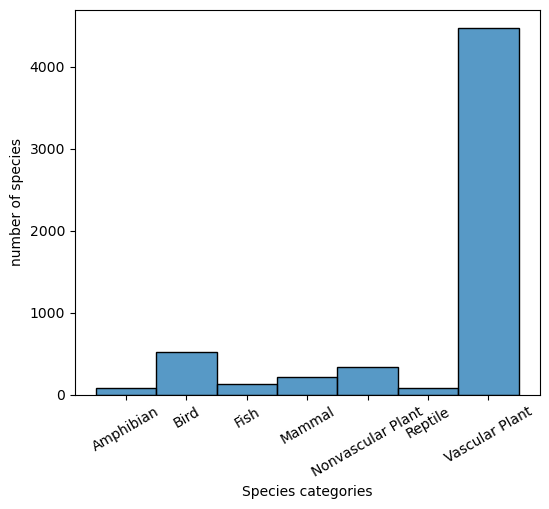

In [397]:
plt.figure(figsize=(6,5));
sns.histplot(conservationPerPark.category);
plt.xticks(rotation = 30);
plt.xlabel("Species categories");
plt.ylabel('number of species');
plt.show();

In [399]:
conservationStatusCategory = conservationPerPark[conservationPerPark.conservation_status != "No status"].groupby(["conservation_status", "category"])['scientific_name'].count().unstack().reset_index();
print(conservationStatusCategory)
unique_conservation_status = list(conservationStatusCategory.conservation_status.unique());

category conservation_status  Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  Vascular Plant
0                 Endangered        1.0   4.0   3.0     7.0                NaN      NaN             1.0
1                In Recovery        NaN   3.0   NaN     1.0                NaN      NaN             NaN
2         Species of Concern        4.0  72.0   4.0    28.0                5.0      5.0            43.0
3                 Threatened        2.0   NaN   4.0     2.0                NaN      NaN             2.0


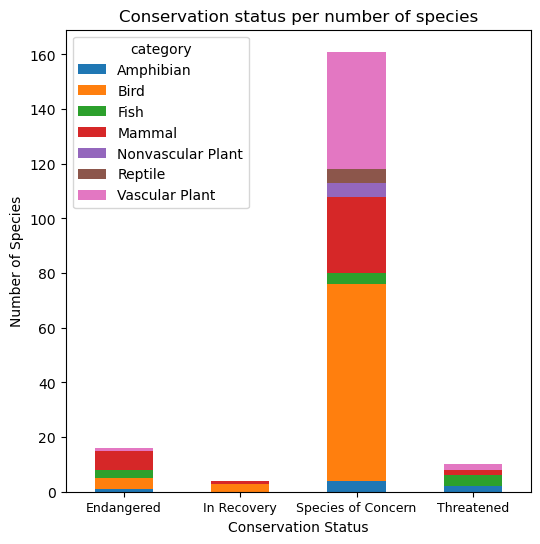

In [400]:
ax = conservationStatusCategory.plot(kind = 'bar', stacked = True, figsize=(6,6));
plt.xticks(fontsize = 9, rotation = 0);
ax.set_xticklabels(unique_conservation_status);
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");
ax.set_title("Conservation status per number of species");
plt.show();

In [401]:
speciesAtRisk = conservationPerPark[conservationPerPark.conservation_status != 'No status'];
speciesAtRisk = speciesAtRisk.drop_duplicates(subset = speciesAtRisk.columns[:2]);
categoryStatus_df = speciesAtRisk[speciesAtRisk.conservation_status != 'No status'].groupby(["category","conservation_status"])['scientific_name'].count().unstack().reset_index();
print(categoryStatus_df);

conservation_status           category  Endangered  In Recovery  Species of Concern  Threatened
0                            Amphibian         1.0          NaN                 4.0         2.0
1                                 Bird         4.0          3.0                68.0         NaN
2                                 Fish         3.0          NaN                 4.0         4.0
3                               Mammal         6.0          NaN                22.0         2.0
4                    Nonvascular Plant         NaN          NaN                 5.0         NaN
5                              Reptile         NaN          NaN                 5.0         NaN
6                       Vascular Plant         1.0          NaN                43.0         2.0


In [ ]:
#fig, [[axis, axis1] , [axis2 , axis3]] = plt.subplots(2, 2, sharey = True, figsize = (6, 5));
#axis= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['Endangered']);
#plt.xlabel("species");
#plt.ylabel('Total count');
#axis1= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['In Recovery']);
#plt.xlabel("species");
#plt.ylabel('Total count');
#axis2= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['Species of Concern']);
#plt.xlabel("species");
#plt.ylabel('Total count');
#axis3= sns.barplot(x = categoryStatus_df.category, y = categoryStatus_df['Threatened']);
#plt.xlabel("species");
#plt.ylabel('Total count');

In [402]:
categoryStatus_df['Total count'] = categoryStatus_df[unique_conservation_status].agg('sum', axis = 1);
#print(unique_conservation_status)
print(categoryStatus_df)

conservation_status           category  Endangered  In Recovery  Species of Concern  Threatened  Total count
0                            Amphibian         1.0          NaN                 4.0         2.0          7.0
1                                 Bird         4.0          3.0                68.0         NaN         75.0
2                                 Fish         3.0          NaN                 4.0         4.0         11.0
3                               Mammal         6.0          NaN                22.0         2.0         30.0
4                    Nonvascular Plant         NaN          NaN                 5.0         NaN          5.0
5                              Reptile         NaN          NaN                 5.0         NaN          5.0
6                       Vascular Plant         1.0          NaN                43.0         2.0         46.0


In [537]:
categoryRiskStatus = conservationPerPark[conservationPerPark.conservation_status == 'No status'];
categoryRiskStatus = categoryRiskStatus.drop_duplicates(subset = categoryRiskStatus.columns[:2]);
categoryRiskStatus['With Risk'] =  categoryRiskStatus.conservation_status != 'No status'
categoryRiskStatus = categoryRiskStatus.groupby(['With Risk','category']).scientific_name.nunique().reset_index().pivot(columns = 'With Risk', index = 'category', values = 'scientific_name').reset_index();
categoryRiskStatus['Total count'] = categoryStatus_df[unique_conservation_status].agg('sum', axis = 1);
categoryRiskStatus.columns = ['category','No Risk','With Risk'];
categoryRiskStatus['With Risk'] = np.round(categoryRiskStatus['With Risk']).astype(int);
print(categoryRiskStatus);
print(categoryRiskStatus['With Risk'].sum());

            category  No Risk  With Risk
0          Amphibian       72          7
1               Bird      413         75
2               Fish      115         11
3             Mammal      146         30
4  Nonvascular Plant      328          5
5            Reptile       73          5
6     Vascular Plant     4216         46
179


In [404]:
categoryRiskStatus = categoryRiskStatus.assign(Percentage = lambda x: (x['With Risk'] / (x['With Risk'] + x['No Risk']) * 100));
print(categoryRiskStatus);

            category  No Risk  With Risk  Percentage
0          Amphibian       72          7    8.860759
1               Bird      413         75   15.368852
2               Fish      115         11    8.730159
3             Mammal      146         30   17.045455
4  Nonvascular Plant      328          5    1.501502
5            Reptile       73          5    6.410256
6     Vascular Plant     4216         46    1.079305


In [405]:
# calling chi_square to verify p-value between Mammal and Bird
contingency1 = [[30, 146],[75, 413]]
chi2_contingency(contingency1);
print(chi2_contingency(contingency1));

(0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))


In [406]:
# calling chi_square to verify p-value between Mammal and Reptile
contingency2 = [[30, 146],[5, 73]]
chi2_contingency(contingency2);
print(chi2_contingency(contingency2));

(4.289183096203645, 0.03835559022969898, 1, array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))


In [407]:
# calling chi_square to verify p-value between Mammal and Fish
contingency3 = [[30, 146],[11, 115]]
chi2_contingency(contingency3);
print(chi2_contingency(contingency3));

(3.647651024981415, 0.0561483484489001, 1, array([[ 23.89403974, 152.10596026],
       [ 17.10596026, 108.89403974]]))


In [408]:
#iterating through the common names parts/words of each specie and listing each part seperately

def isolateNames(cName):
    for symbol in string.punctuation:
        cName = cName.replace(symbol, '');
    return cName;

common_Names = conservationPerPark[conservationPerPark.category == "Mammal"].common_names.apply(isolateNames).str.split().tolist();
cleanRows = [];
for name in common_Names:
    name = list(dict.fromkeys(name));
    cleanRows.append(name);

commonNamesList = list(chain.from_iterable(name if isinstance(name, list) else [name] for name in cleanRows));
print(commonNamesList);

['Eurasian', 'Elk', 'Moose', 'Yellowstone', 'Moose', 'Antelope', 'Pronghorn', 'Pallid', 'Bat', 'Sierra', 'Nevada', 'Mountain', 'Beaver', 'Ringtail', 'Bison', 'Buffalo', 'Northern', 'Short', 'Tailed', 'Shrew', 'ShortTailed', 'American', 'Bison', 'Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated', 'GoldenMantled', 'Ground', 'Squirrel', 'Coyote', 'Gray', 'Wolf', 'Gray', 'Wolf', 'Gray', 'Wolf', 'Red', 'Wolf', 'American', 'Beaver', 'American', 'Beaver', 'Beaver', 'Rocky', 'Mountain', 'Elk', 'Wapiti', 'Or', 'Elk', 'California', 'Pocket', 'Mouse', 'Southern', 'RedBacked', 'Vole', 'Gappers', 'RedBacked', 'Vole', 'StarNosed', 'Mole', 'Rafinesques', 'BigEared', 'Bat', 'MuleEared', 'Bat', 'Pacific', 'Townsends', 'BigEared', 'Western', 'LongEared', 'LumpNosed', 'Townsends', 'BigEared', 'Bat', 'Least', 'Shrew', 'Virginia', 'Opossum', 'Virginia', 'Opossum', 'Oppossum', 'Big', 'Brown', 'Bat', 'Big', 'Brown', 'Bat', 'Feral', 'Horse', 'Common', 'Porcupine', 'Porcupine', 'Spotted', 'Bat', 'Western

In [409]:
common_words_count = [];

for name in commonNamesList:
    count = commonNamesList.count(name);
    common_words_count.append((name,count));

common_words_df = pd.DataFrame(set(common_words_count), columns =['Word', 'Count']).sort_values("Count", ascending = False);
print(common_words_df.head(10));

         Word  Count
194       Bat     23
159     Shrew     18
202    Myotis     17
76      Mouse     16
11   Chipmunk     13
146  Squirrel     12
88   American     12
65    Eastern     11
40       Vole     11
118  Mountain     10


In [410]:
conservationPerPark['bat specie'] = conservationPerPark.common_names.str.contains(r"\bBat\b", regex = True)
print(conservationPerPark[conservationPerPark['bat specie']]);

park_name category            scientific_name                                       common_names conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park  Total count  bat specie
731         Mammal         Antrozous pallidus                             Pallid Bat, Pallid Bat  Species of Concern                   67                                   61                        244                     134          506        True
753         Mammal   Corynorhinus rafinesquii                         Rafinesque's Big-Eared Bat           No status                   57                                   80                        259                     188          584        True
754         Mammal    Corynorhinus townsendii  Mule-Eared Bat, Pacific Townsend's Big-Eared B...           No status                  113                                   92                        253                     147          605        T

In [416]:
conservationPerPark['shrew specie'] = conservationPerPark.common_names.str.contains(r"\Shrew\b", regex = True)
print(conservationPerPark[conservationPerPark['shrew specie']]);

park_name category     scientific_name                                       common_names conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park  Total count  bat specie  shrew specie
735         Mammal  Blarina brevicauda  Northern Short Tailed Shrew, Northern Short-Ta...           No status                   77                                   86                        244                     185          592       False          True
756         Mammal     Cryptotis parva                                        Least Shrew           No status                  153                                   68                        277                     152          650       False          True
881         Mammal      Sorex cinereus         Cinereus Shrew, Common Shrew, Masked Shrew           No status                  117                                   66                        264                     121        

In [415]:
print(conservationPerPark.head().sort_values("Total count", ascending = False));

park_name   category                    scientific_name               common_names conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park  Total count  bat specie  shrew specie
3          Amphibian                   Ambystoma opacum         Marbled Salamander           No status                  115                                   78                        301                     167          661       False         False
2          Amphibian  Ambystoma mavortium melanostictum  Blotched Tiger Salamander           No status                   84                                   79                        287                     157          607       False         False
4          Amphibian               Ambystoma talpoideum            Mole Salamander           No status                  105                                   82                        254                     105          546       False         Fa

In [528]:
#bat population distribution
batsDistribution = conservationPerPark[conservationPerPark['bat specie'] == True];
batsDistribution = batsDistribution.drop(columns = ['category','scientific_name','common_names','bat specie','shrew specie','Total count']);
print(batsDistribution.head());
#shrew population distribution
shrewDistribution = conservationPerPark[conservationPerPark['shrew specie'] == True];
shrewDistribution = shrewDistribution.drop(columns = ['category','scientific_name','common_names','bat specie','shrew specie','Total count']);
print(shrewDistribution.head());

park_name conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park
731        Species of Concern                   67                                   61                        244                     134
753                 No status                   57                                   80                        259                     188
754                 No status                  113                                   92                        253                     147
755                 No status                  113                                   92                        253                     147
759        Species of Concern                   92                                   73                        231                     127
park_name conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park
735                 No stat

In [529]:
batsDistribution['conservation_status'] = batsDistribution['conservation_status'].replace(['Species of Concern','Threatened','Endangered'],'Risk');
print(batsDistribution.head());

park_name conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park
731                      Risk                   67                                   61                        244                     134
753                 No status                   57                                   80                        259                     188
754                 No status                  113                                   92                        253                     147
755                 No status                  113                                   92                        253                     147
759                      Risk                   92                                   73                        231                     127


In [530]:
shrewDistribution['conservation_status'] = shrewDistribution['conservation_status'].replace(['Species of Concern','Threatened','Endangered'],'Risk');
print(shrewDistribution.head());

park_name conservation_status  Bryce National Park  Great Smoky Mountains National Park  Yellowstone National Park  Yosemite National Park
735                 No status                   77                                   86                        244                     185
756                 No status                  153                                   68                        277                     152
881                 No status                  117                                   66                        264                     121
882                 No status                  117                                   66                        264                     121
883                 No status                  123                                  100                        285                     157


In [531]:
batsDistribution = batsDistribution.groupby("conservation_status").sum().T;
print(batsDistribution)

conservation_status                  No status  Risk
park_name                                           
Bryce National Park                       1081  1027
Great Smoky Mountains National Park        890   658
Yellowstone National Park                 2790  2498
Yosemite National Park                    1656  1393


In [532]:
shrewDistribution = shrewDistribution.groupby("conservation_status").sum().T;
print(shrewDistribution)

conservation_status                  No status  Risk
park_name                                           
Bryce National Park                       1758    71
Great Smoky Mountains National Park       1209    59
Yellowstone National Park                 4408   193
Yosemite National Park                    2502   140


### Side by side plot for bat distribution in each park

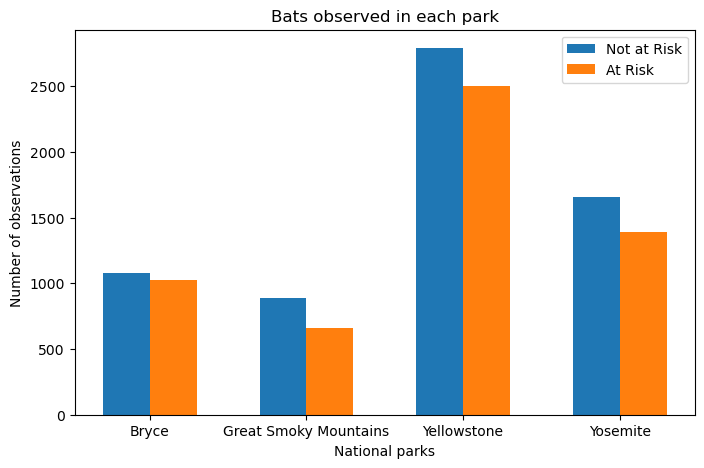

In [533]:
N = 4;
D = np.arange(N);
width = 0.3;
plt.figure(figsize=(8,5))

plt.bar(D, batsDistribution['No status'] , width, label = 'Not at Risk');
plt.bar(D + width, batsDistribution['Risk'], width, label = 'At Risk');
plt.xticks(D + width / 2, ('Bryce', 'Great Smoky Mountains', 'Yellowstone','Yosemite'));
plt.xlabel('National parks');
plt.ylabel('Number of observations');
plt.title('Bats observed in each park');
plt.legend();
plt.show();


### Side by side plot for shrew distribution in each park

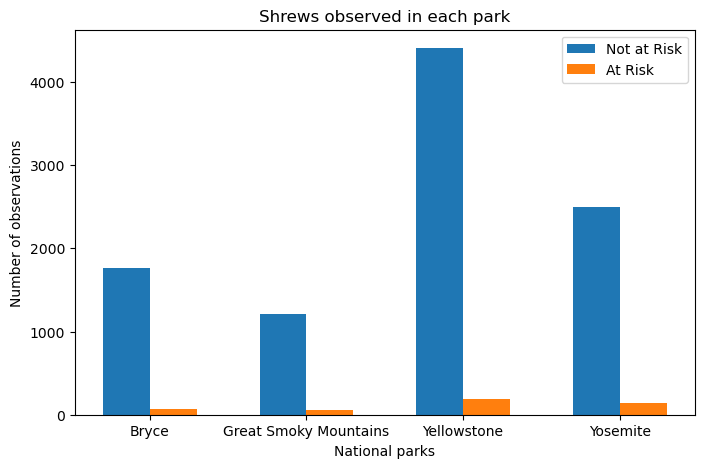

In [535]:
N = 4;
D = np.arange(N);
width = 0.3;
plt.figure(figsize=(8,5))

plt.bar(D, shrewDistribution['No status'] , width, label = 'Not at Risk');
plt.bar(D + width, shrewDistribution['Risk'], width, label = 'At Risk');
plt.xticks(D + width / 2, ('Bryce', 'Great Smoky Mountains', 'Yellowstone','Yosemite'));
plt.xlabel('National parks');
plt.ylabel('Number of observations');
plt.title('Shrews observed in each park');
plt.legend();
plt.show();

# Conclusion

- What is the distribution of conservation status for species?

**5363** of observed species are protected for **179** are endagered or at risk.

- Are certain types of species more likely to be endangered?

**Mammals and Birds** apears to be the most likely species to be endangered.

- Are the differences between species and their conservation status significant?

The difference between  **Mammal and Reptile (0.039)** and between **Mammal and Fish (0.056)** show a significant difference.

- Which animal is most prevalent and what is their distribution amongst parks?

**Bats and Shrewds** are the most prevalent and are highly observed in Yellowstone National Park.